# Bayesian Persuasion

In this post we explore the connections between standard machine learning methods and bayesian inference. We also show how a neural network can be made fully bayesian.

The first section is a refresher on bayesian stats, then we discuss the bayesian interpretation of your usual machine learning models, last we implement a bayesian neural network in jax.

## Back to Bayesics

A common view of machine learning is as an optimization problem over a neural network's parameters to minimize a loss function.

For example given a NN with parameters $\theta$ we may aim to find

$$\hat{\theta} = \arg\min_{\theta} \Vert{f_{\theta}-x}\Vert^2$$

In case of a linear model $f$ this is the familiar setting of maximum likelihood estimation. This carries over to the general non-linear case, taking a probabilist view we are finding $\theta$ satisfying (under certain assumptions about measurement errors).
$$\hat{\theta} = \arg\max_{\theta} \log{p(x | \theta )}$$

In plain text this reads "which choice of $\theta$ would make seeing this data the most likely?"
Note, this does not answer the question "which $\theta$ is the most likely given the data we've observed?"

Generally we are interested in estimating $\theta$ based on the data $p(\theta | x)$, not the other way around. The way forward is Bayes theorem:

$$p(\theta|x) = \frac{p(x|\theta)p(\theta)}{p(x)}$$

The denominator $p(x)$ is problematic, how are we supposed to figure out the objective likelihood of the data in the real world? $p(x)$ forms a normalizing constant (w.r.t $\theta$) ensuring $p( \theta | x)$ integrates to 1. Bayes theorem is often reformulated as 

$$p(\theta|x) \propto p(x|\theta)p(\theta)$$

where the right hand side is an unnormalized probability. 

We have one other issue, what is $p(\theta)$? If we knew the parameters we wouldn't be solving for them!
Maybe we do have some hunch about the scale and behaviour of the parameters, what if we just assign $\theta$ a probability distribution a priori? This distribution is a design choice we have to make and $p(\theta$) is called the prior distribution of $\theta$, prior as in prior beliefs or assumptions.

Note that the improper prior $p(\theta)=1$ would make $p(\theta|x) \propto p(x|\theta)$ everywhere (and thus equal?). This is often a valid choice even though $p(\theta)=1$ is not a distribution: it doesn't integrate to 1, it's not even integrable. The full right hand side can be integrable though which acts as a theoretical saving grace.

Let's start by implementing our own bayesian linear regression. In the following sections we'll work with log probabilities

$$\log{p(\theta|x)} \propto \log{p(x|\theta)} + \log{p(\theta)}$$


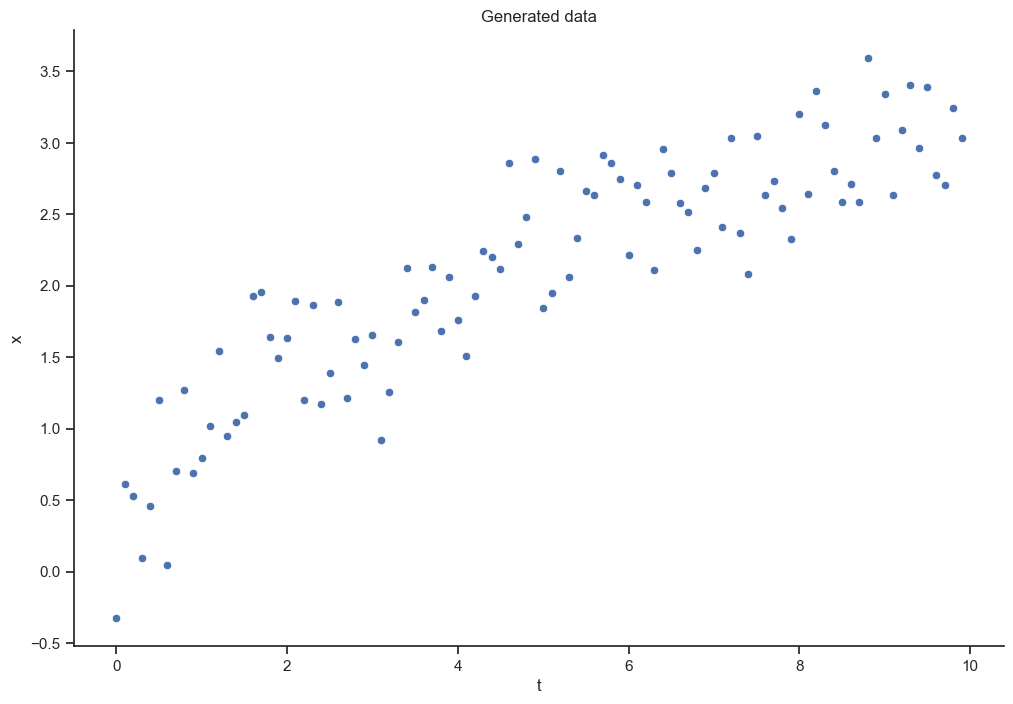

In [1]:
import numpy as np
np.random.seed(123)
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()
sns.set_style("ticks")
sns.color_palette("dark")
plt.rc("axes.spines", top=False, right=False)
plt.rc("figure", figsize= (12,8))

# generate synthetic data
t = np.arange(0,10, 0.1)
x = t**0.5 + np.random.randn(len(t))*0.3
sns.scatterplot(x=t, y=x);
plt.title("Generated data");
plt.xlabel("t");
plt.ylabel("x");

We have generated data that is not inherently linear, even though the errors are i.i.d normal, let's see how this goes.

Our model will be very simple, a linear model in 1 parameter without intercept.

We'll use a $N(0,1)$ prior on the regression parameter $\theta$, encoding an assumption that it is relatively small. It's a weakly informative prior that doesn't nudge the model in any particular direction. For example if we suspect $\theta>0$ we could have let the choice of prior reflect this prior belief.

We will also assume the likelihood $p(x(t)| \theta) \sim N(\theta t,1)$ according to our linear assumptions.

Next we want to define the log probabilities of $p(x | \theta)$ and $p(\theta)$: our likelihood and prior respectively.

In [2]:
def lm(theta, t):
    # our linear model
    return theta*t

def logprob_norm(data, mu=0, sigma=1):
    # log of the normal pdf
    return -np.log(sigma) - np.log(2*np.pi)/2 - (data - mu)**2 / (2 * sigma**2)

def logprob_prior(theta, mu=0, sigma=1):
    return logprob_norm(theta, mu, sigma)

def logprob_likelihood(x, theta, t,  sigma=1):
    return logprob_norm(x, lm(theta, t), sigma)

Now how do we sample from the posterior $p(\theta | x)$ given these unnormalized log probabilities? There are many sophisticated ways to do this including HMC and SVI, but here we'll use the Gumbel max trick.

In [3]:
N_samples=10000
log_posteriors = []
thetas = []


# for loop for relative readability
for _ in range(N_samples):
    # sample from theta prior
    theta_prior = np.random.normal()
    thetas.append(theta_prior)

    # log probabilities of prior and likelihood
    lpp = logprob_prior(theta_prior)
    lpl = np.sum(logprob_likelihood(x, theta_prior, t))
    
    # log probability of posterior.
    lppost = lpp + lpl
    log_posteriors.append(lppost)

log_posteriors=np.array(log_posteriors)
posterior_samples=[]

for _ in range(N_samples):
    # use standard gumbel variables to sample from theta based on the log probs
    gumbels=np.random.gumbel(0,1,N_samples)
    theta_ind=np.argmax(log_posteriors + gumbels)
    posterior_samples.append(thetas[theta_ind])

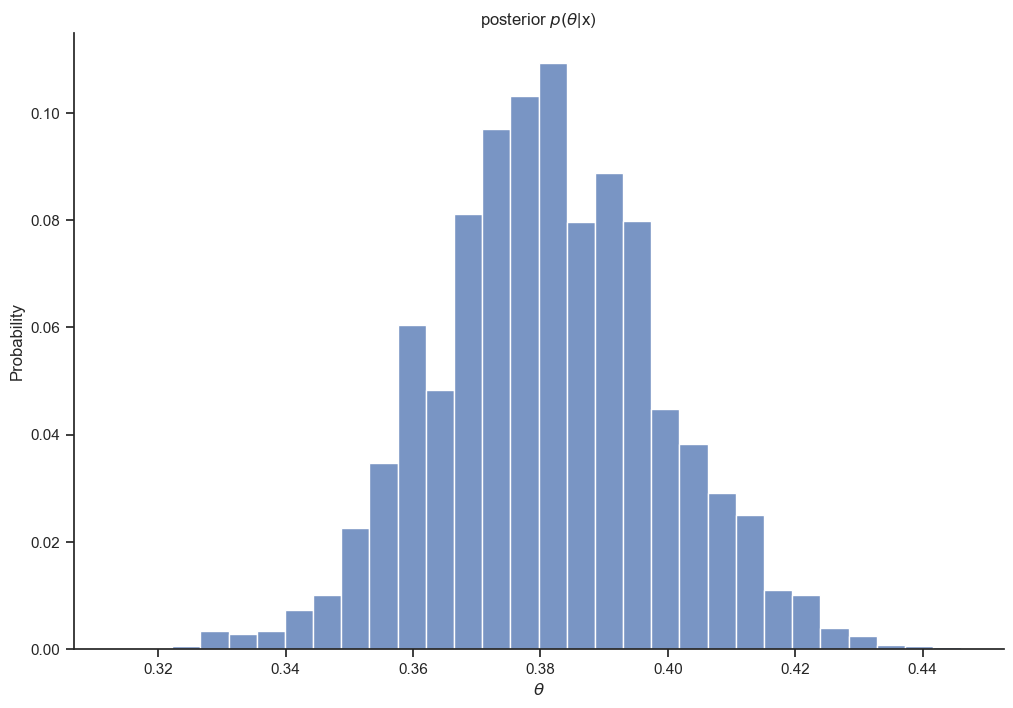

In [4]:
sns.histplot(posterior_samples, bins=30, stat= "probability");
plt.title(r"posterior $p(\theta$|x)");
plt.xlabel(r"$\theta$");

In [5]:
mu=np.mean(posterior_samples)
std=np.std(posterior_samples)
mu,std

(0.38109701571399685, 0.017641487193737412)

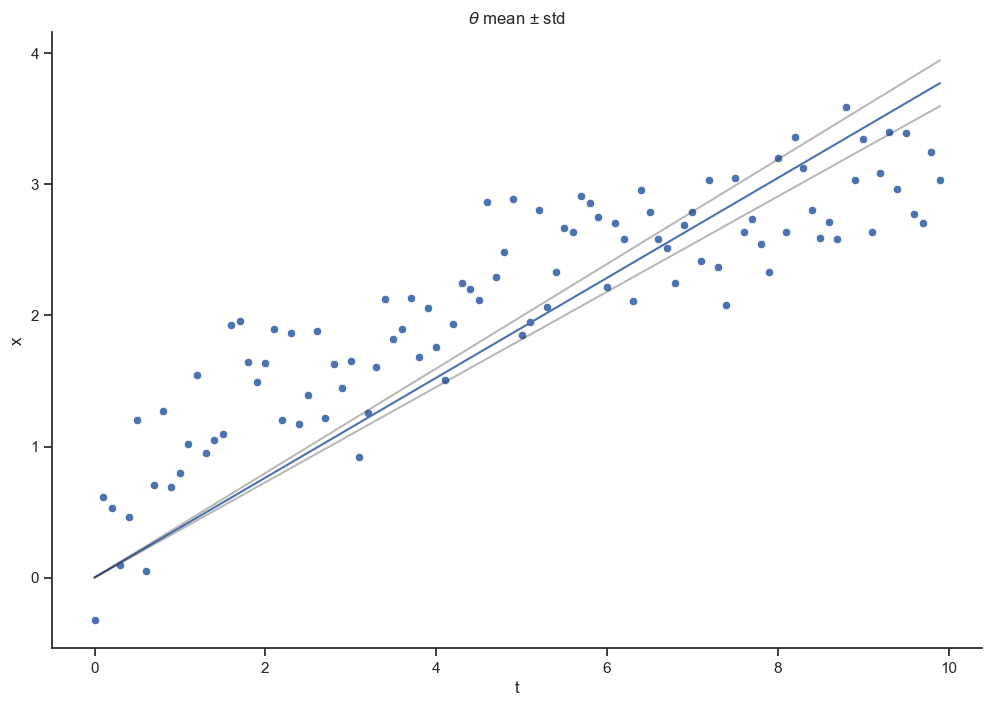

In [6]:
sns.scatterplot(x=t, y=x);
sns.lineplot(x=t, y=mu*t);
sns.lineplot(x=t, y=(mu-std)*t, color='k', alpha=0.3);
sns.lineplot(x=t, y=(mu+std)*t, color='k', alpha=0.3);
plt.title(r"$\theta$ mean ± std");
plt.xlabel("t");
plt.ylabel("x");

We have successfully sampled from the posterior distribution $p(\theta|x)$ and found that $\theta \approx 0.38$ with quite some certainty. 

What about the predicted values $\tilde{x}(t)$ given this model? This is also probabilistic given the posterior distribution of $\theta$. These values are distributed according to the posterior predictive distribution $$p(\tilde{x}(t)|x) = \int p(\tilde{x}(t)|\theta ) p(\theta|x(t)) d\theta$$

We're essentially looking for the probability of a new $\tilde{x}$ given all our data x by averaging over $\theta$ from the posterior.

For example $\tilde{x}|t=4$

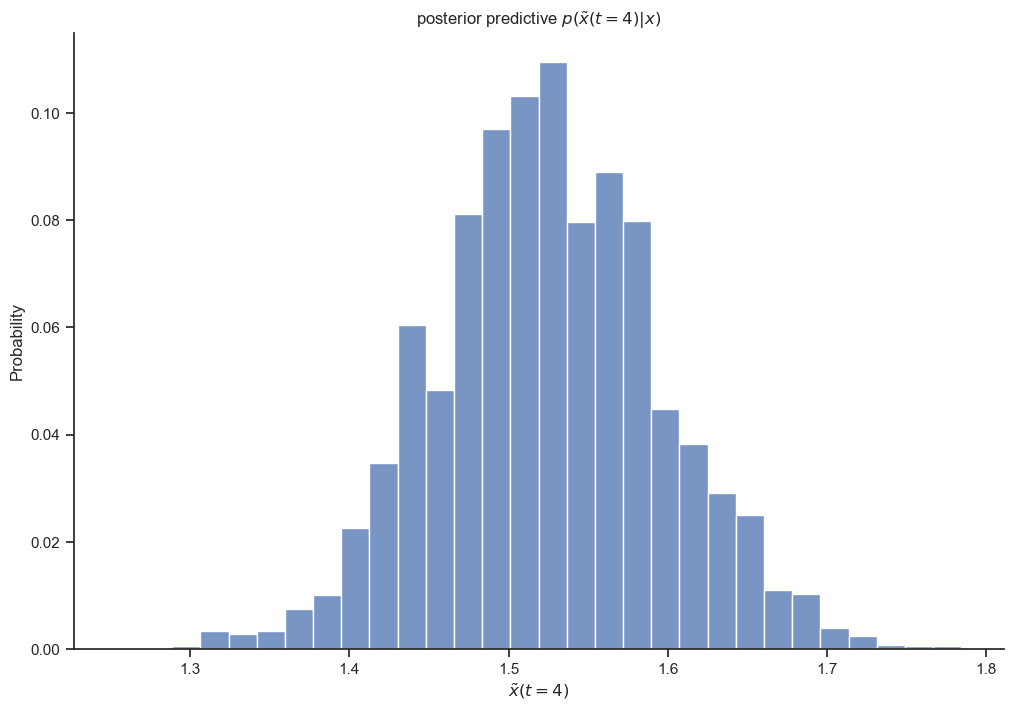

In [7]:
posterior_predictive_samples=[lm(theta, 4) for theta in posterior_samples]
sns.histplot(posterior_predictive_samples, bins=30, stat="probability");
plt.title(r"posterior predictive $p(\tilde{x}(t=4)|x)$");
plt.xlabel(r"$\tilde{x}(t=4)$");

The square root of 4 is actually 2, maybe it's time to improve the model?

## Machine Learning Problem

Let's explore the NN mentioned in the beginning, we define a model in Flax NNX and minimize the MSE.

In [8]:
import jax
import jax.numpy as jnp
from flax import nnx
from jax.random import PRNGKey
import optax

import pandas as pd

In [9]:
class NN(nnx.Module):
    def __init__(self, dim_in=1, dim_out=1,  n_hidden = 3, act = nnx.sigmoid, *, key):
        self.act = act
        keys = jax.random.split(key, 3)

        self.layer1 = nnx.Linear(dim_in, n_hidden, rngs = nnx.Rngs(params=keys[0]))
        self.layer2 = nnx.Linear(n_hidden, n_hidden, rngs = nnx.Rngs(params=keys[1]))
        self.layer3 = nnx.Linear(n_hidden, dim_out, rngs = nnx.Rngs(params=keys[2]), use_bias=False)

    def __call__(self, x):

        x = self.layer1(x)
        x = self.act(x)
        x = self.layer2(x)
        x = self.act(x)
        return self.layer3(x)
    
    def apply(self, params, x):
        # will be used later
        nnx.update(self, params)

        return self.__call__(x)

@nnx.jit
def loss_fn(model, t, x):
    y = model(t)
    return jnp.mean((x-y)**2)

In [10]:
key=PRNGKey(42)
model = NN(key=key)

In [11]:
lr=1e-2
optimizer = nnx.Optimizer(model, optax.adam(lr))
metrics = nnx.MultiMetric(
  loss=nnx.metrics.Average('loss'),
)

In [12]:
@nnx.jit
def train_step(model, optimizer, metrics, t, x):
  """Train for a single step."""
  grad_fn = nnx.value_and_grad(loss_fn)
  loss, grads = grad_fn(model, t, x)
  metrics.update(loss=loss)
  optimizer.update(grads)

In [13]:
for _ in range(1000):
    train_step(model, optimizer, metrics, jnp.expand_dims(t,-1), jnp.expand_dims(x,-1))

In [14]:
x_hat=model(jnp.expand_dims(t,-1))

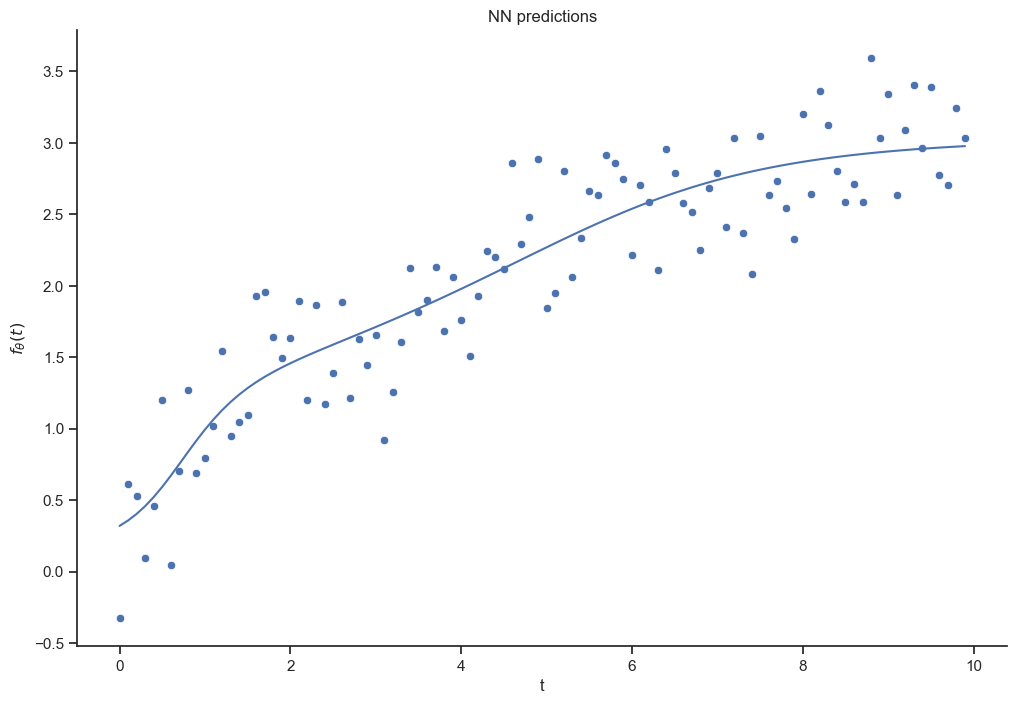

In [15]:
sns.scatterplot(x=t, y=x);
sns.lineplot(x=t, y=x_hat.reshape(-1));
plt.title("NN predictions");
plt.xlabel("t");
plt.ylabel(r"$f_{\theta}(t)$");

Overfitting aside we have found parameters $\theta$ of the neural network $f_{\theta}$ that minimize our loss function:

$$\Vert x - f_{\theta}(t) \Vert^2$$

Remember we generated the data with normal i.i.d noise, in a probabilistic setting it would thus be prudent to model the data generating distribution as 

$$ x(t) \sim N(f_{\theta}(t), \sigma)$$

Performing a maximum likelihood fit we would maximize the log likelihood $$\log {p(x(t) | \theta)} = \log{ \frac{e^{-\frac{\Vert x-f_{\theta}(t) \Vert^2}{2 \sigma^2}}}{\sqrt{2\pi \sigma^2}}} \propto C - \Vert x - f_{\theta}(t) \Vert^2$$

Feels familiar? Maximizing the log likelihood is the same as minimizing our MSE loss function.


One possible remedy for overfitting is regularization of the neural network parameters, for example $L_2$-regularization would add a term $\beta \Vert \theta \Vert^2$ to the loss function, thereby penalizing large weights. This generally has a smoothing effect on the output.

The loss function would become $$\Vert x - f_{\theta}(t) \Vert^2 + \beta \Vert \theta - 0 \Vert^2$$

The connection to our bayesian linear regression is obvious if we flip the sign, these are the unnormalized negative log probabilities of normal priors and likelihoods. Adding regularization to our loss function turns the (frequentist) maximum likelihood estimate into a (bayesian) maximum a posteriori estimate (MAP).

$$\hat{\theta} = \arg\max_{\theta} \log{p(\theta | x )} = \arg\max_{\theta} \log{p(x | \theta )} + \log{p(\theta )} = \arg\min_{\theta} \Vert x - f_{\theta}(t) \Vert^2 + \beta \Vert \theta\Vert^2$$

If you were using $L_2$-regularization you were a bayesian all along! Whether you call it regularization, shrinkage or a prior the effect is the same: constraining parameter values. Similarly, when you use MSE loss you're applying a filter on the data, assuming normal i.i.d errors. Probability theory just refuses to go away!

$L_1$-regularization? A Laplace prior.

MAE loss? Laplace likelihood.

## Bayesian Neural Network

We learned that the standard neural network has a bayesian interpretation, but something is missing. We didn't manage to sample from our posterior $p(\theta | x)$, we just found a point estimate of $\theta$. In order to be fully bayesian we'd like to average over this posterior distribution when predicting new values.

Drawing samples from the posterior is a difficult problem in general, the standard way is to sample using MCMC (typically HMC) or SVI. These samplers can be found in a variety of packages and part of excellent PPLs like Numpyro, PYMC and Turing.jl. Here we will try out the Blackjax package and its SVI algorithm **pathfinder**.

In [16]:
data=(jnp.expand_dims(t,-1), jnp.expand_dims(x,-1))

In [17]:
logprob_norm_jax = jax.scipy.stats.norm.logpdf

We'll use the arbitrary priors $p(\theta_i) \sim N(0,100)$ on the neural network parameters. The log likelihood is proportional to $1/\sigma^2$, in this case roughly equivalent to a $L_2$-regularization parameter $\beta \approx$ 1e-4.

In [18]:
@jax.jit
def logprior_fn(params):
    leaves, _ = jax.tree_util.tree_flatten(params)
    flat_params = jnp.concatenate([jnp.ravel(a) for a in leaves])
    return jnp.sum(logprob_norm_jax(flat_params, 0, 100))

@jax.jit
def loglikelihood_fn(params, data):
    t, x = data
    return jnp.sum(logprob_norm_jax(x, model.apply(params, t), .5 ))

@jax.jit
def logdensity_fn(params):
    return logprior_fn(params) + loglikelihood_fn(params, data)

In [19]:
import blackjax
num_warmup = 10000
num_samples = 1000

In [20]:
rng_key = PRNGKey(0)
rng_key, rng_subkey = jax.random.split(rng_key)

model = NN(act=nnx.sigmoid ,key=rng_key)
state = nnx.state(model)
param = state.filter(nnx.Param)

pathfinder_state, infos = blackjax.vi.pathfinder.approximate(
    rng_key=rng_subkey,
    logdensity_fn=logdensity_fn,
    initial_position=param,
    num_samples=num_warmup,
    ftol=1e-12,
    gtol=1e-12,
    maxiter=50,
    maxls=10000

)

# sample from the posterior
rng_key, rng_subkey = jax.random.split(rng_key)
posterior_samples, _ = blackjax.vi.pathfinder.sample(
    rng_key=rng_subkey,
    state=pathfinder_state,
    num_samples=num_samples,
)


In [21]:
infos.path.elbo

Array([-2.8448083e+08,           -inf,           -inf,           -inf,
                 -inf,           -inf,           -inf,           -inf,
                 -inf,           -inf,           -inf,           -inf,
                 -inf,           -inf,           -inf,           -inf,
                 -inf,           -inf,           -inf,           -inf,
                 -inf, -1.7234183e+02,           -inf, -1.7494684e+02,
       -1.6947232e+02, -1.8210046e+02,           -inf,           -inf,
       -1.7699753e+02,           -inf,           -inf,           -inf,
                 -inf,           -inf,           -inf, -1.7910097e+02,
                 -inf,           -inf, -1.8681752e+02, -2.9257407e+02,
                 -inf, -1.8813480e+02,           -inf,           -inf,
       -2.0863950e+02,           -inf, -1.9126106e+02, -1.8669675e+02,
                 -inf,           -inf,           -inf], dtype=float32)

Ouch! This did not converge well, maybe this algorithm isn't suitable for our use case, maybe the geometry of the posterior is difficult? There are plenty of other samplers to try for those so inclined.

Let's fall back on NUTS, a HMC MCMC sampler.

In [22]:
model = NN(act=nnx.sigmoid ,key=rng_key)
state = nnx.state(model)
param = state.filter(nnx.Param)

In [23]:
adapt = blackjax.window_adaptation(
    blackjax.nuts, logdensity_fn, target_acceptance_rate=0.8
)
rng_key, warmup_key = jax.random.split(rng_key)

# warm up the model in order to reach equilibrium
(last_state, parameters), _ = adapt.run(warmup_key, param, num_warmup)
kernel = blackjax.nuts(logdensity_fn, **parameters).step

In [24]:
keys = jax.random.split(rng_key, num_samples)
def step_fn(key, state):
        return kernel(key, state)

# sample
s, info = jax.vmap(step_fn,in_axes=(0, None))(keys, last_state)

posterior_params = s.position

In [25]:
def eval_fn(params, t):
    return model.apply(params, jnp.expand_dims(t,-1))

In [26]:
# apply model with weights sampled from the posterior distribution, e.g. draw x from the posterior predictive
res = jax.vmap(eval_fn, in_axes=(0, None))(posterior_params, t).squeeze()

# predict out of sample
t_oos=jnp.arange(0,20,.1)
res_oos = jax.vmap(eval_fn, in_axes=(0, None))(posterior_params, t_oos).squeeze()

In [27]:
df_res=pd.DataFrame(res).T
df_oos=pd.DataFrame(res_oos).T

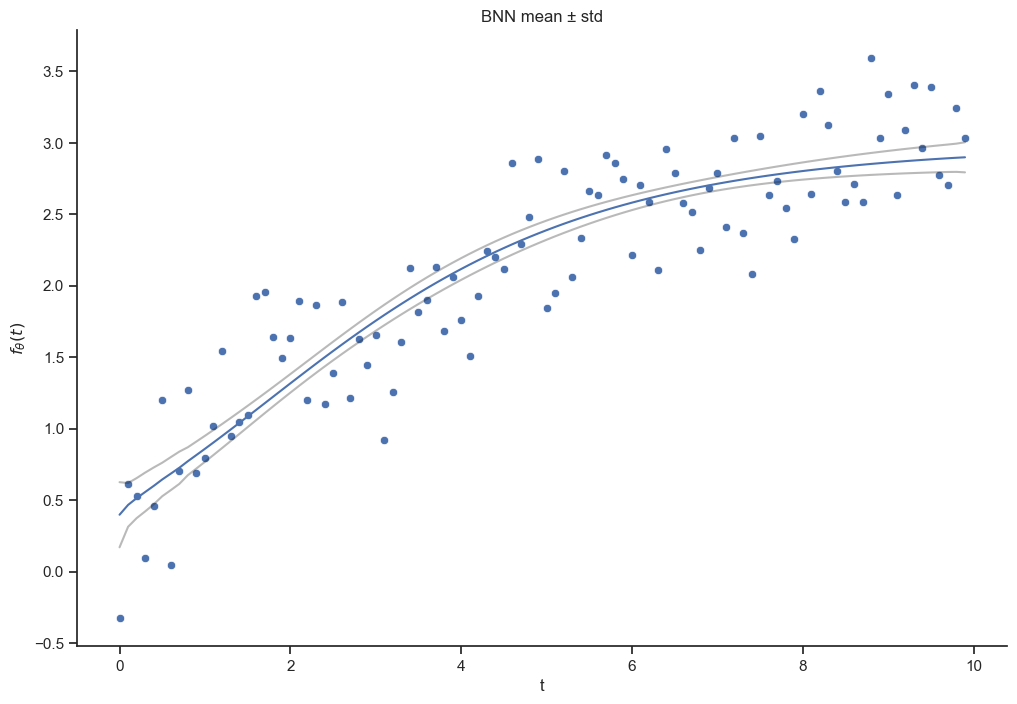

In [28]:
means=df_res.mean(axis=1)
stds = df_res.std(axis=1)

sns.scatterplot(x = t, y = x);
sns.lineplot(x = t, y = means)
sns.lineplot(x = t, y = means + stds, color="k", alpha=0.3);
sns.lineplot(x = t, y = means - stds, color="k", alpha=0.3);
plt.title(r"BNN mean ± std");
plt.xlabel("t");
plt.ylabel(r"$f_{\theta}(t)$");

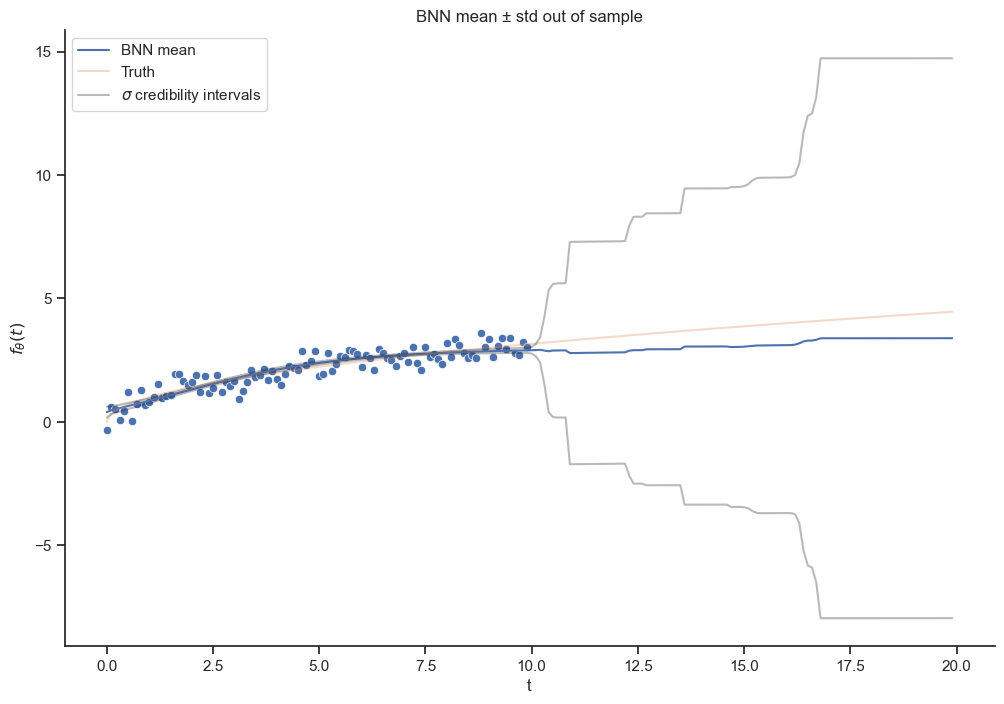

In [33]:
means=df_oos.mean(axis=1)
stds = df_oos.std(axis=1)

sns.lineplot(x=t_oos, y=means);
sns.lineplot(x=t_oos, y=np.sqrt(t_oos), alpha=0.3)
sns.lineplot(x=t_oos, y=means + stds, color="k", alpha=0.3);
sns.lineplot(x=t_oos, y=means - stds, color="k", alpha=0.3);
sns.scatterplot(x=t, y=x);
plt.title(r"BNN mean ± std out of sample");
plt.xlabel("t");
plt.ylabel(r"$f_{\theta}(t)$");
plt.legend(["BNN mean", "Truth", r"$\sigma$ credibility intervals"]);

When using a BNN our predictions are samples drawn from the posterior predictive distribution, this has the benefit of informing us about the model's uncertainty. We see that the standard deviation grows when we try to extrapolate. Maybe someday LLMs will have this feature instead of confidently recommending eating rocks.

![](GPT_rocks.jpeg)